In [1]:
import pickle
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Computing the Camera Calibration

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    undist = np.copy(img)
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undst = cv2.undistort(undist, mtx, dist, None, mtx)
    return undst

In [4]:
objpoints = []
imgpoints = []
images = glob.glob('./camera_cal/calibration*.jpg')
nx=9
ny=6
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        imgpoints.append(corners)
        objpoints.append(objp)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [5]:
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [6]:

image_calibrate = mpimg.imread('./camera_cal/calibration2.jpg')
undistorted_calibrated = undistort(image_calibrate)
img_size = (undistorted_calibrated.shape[1], undistorted_calibrated.shape[0])
print(img_size)

(1280, 720)


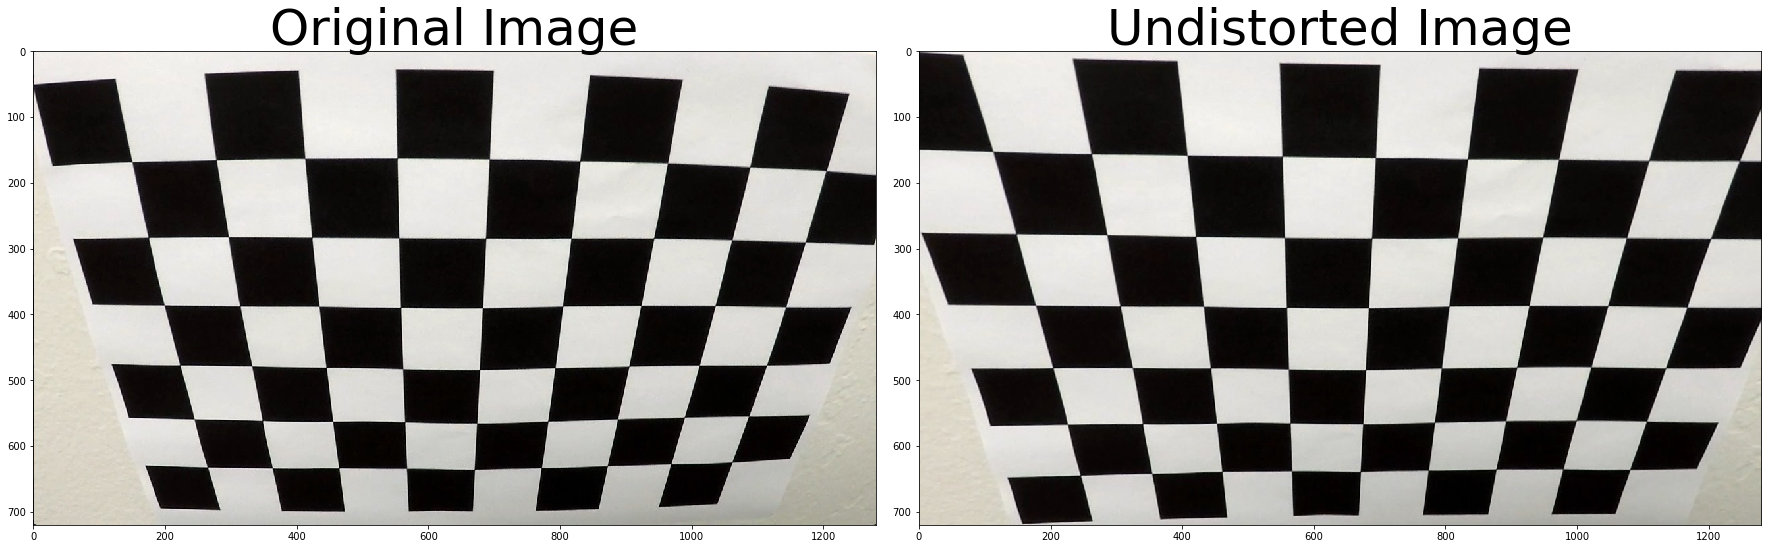

In [7]:
#Printing a camera calibrated image after undistortion applied to it.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_calibrate)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_calibrated)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Destortion correction on test images

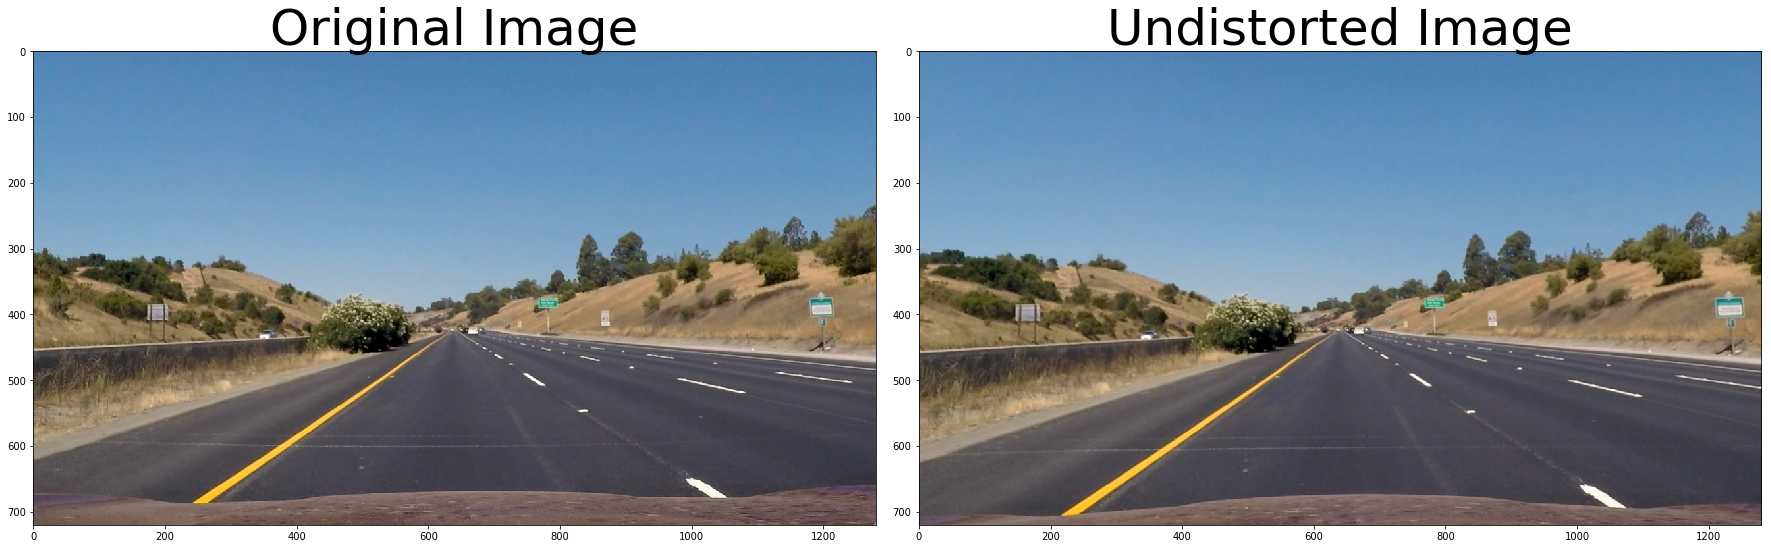

In [8]:
#Reading an image from the the test_images folder and checking for distortion correction
test_img = mpimg.imread('./test_images/straight_lines1.jpg')
#Image after using applied to undistorted function
undistorted_img = cal_undistort(test_img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_img, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Calculation for Color/ Gradient Threshold

In [9]:
#Calculating abs_sobel_threshold for one of the images provided
def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    height=img.shape[0]
    width=img.shape[1]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    #Applying region of masking on the image
    mask = np.zeros_like(binary_output)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    abs_sobel_img = cv2.bitwise_and(binary_output, mask)
    return abs_sobel_img

#calculating magnitude threshold value
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    height=img.shape[0]
    width=img.shape[1]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    #Applying region of masking on the image
    mask = np.zeros_like(binary_output)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    mag_thresh_img = cv2.bitwise_and(binary_output, mask)
    return mag_thresh_img

#Calculating direction threshold value
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    height=img.shape[0]
    width=img.shape[1]    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grdir=np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(grdir)
    binary_output[(grdir >= thresh[0]) & (grdir <= thresh[1])] = 1
    #Applying region of masking on the image
    mask = np.zeros_like(binary_output)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    dir_threshold_img = cv2.bitwise_and(binary_output, mask)
    return dir_threshold_img

#Calculating the HLS value threshold
def hls_image(img,thresh=(120,150)):
    #thresh = (80, 255)
    #thresh1 = (100, 255)
    height=img.shape[0]
    width=img.shape[1]
    hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    h=hls[:,:,0]
    l=hls[:,:,1]
    s=hls[:,:,2]
    binary_hls=np.zeros_like(s)
    binary_hls[(l > thresh[0]) & (s > thresh[1])]=1
    mask = np.zeros_like(binary_hls)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    hls_image_out = cv2.bitwise_and(binary_hls, mask)
    return hls_image_out

Abs_Sobel_threshold


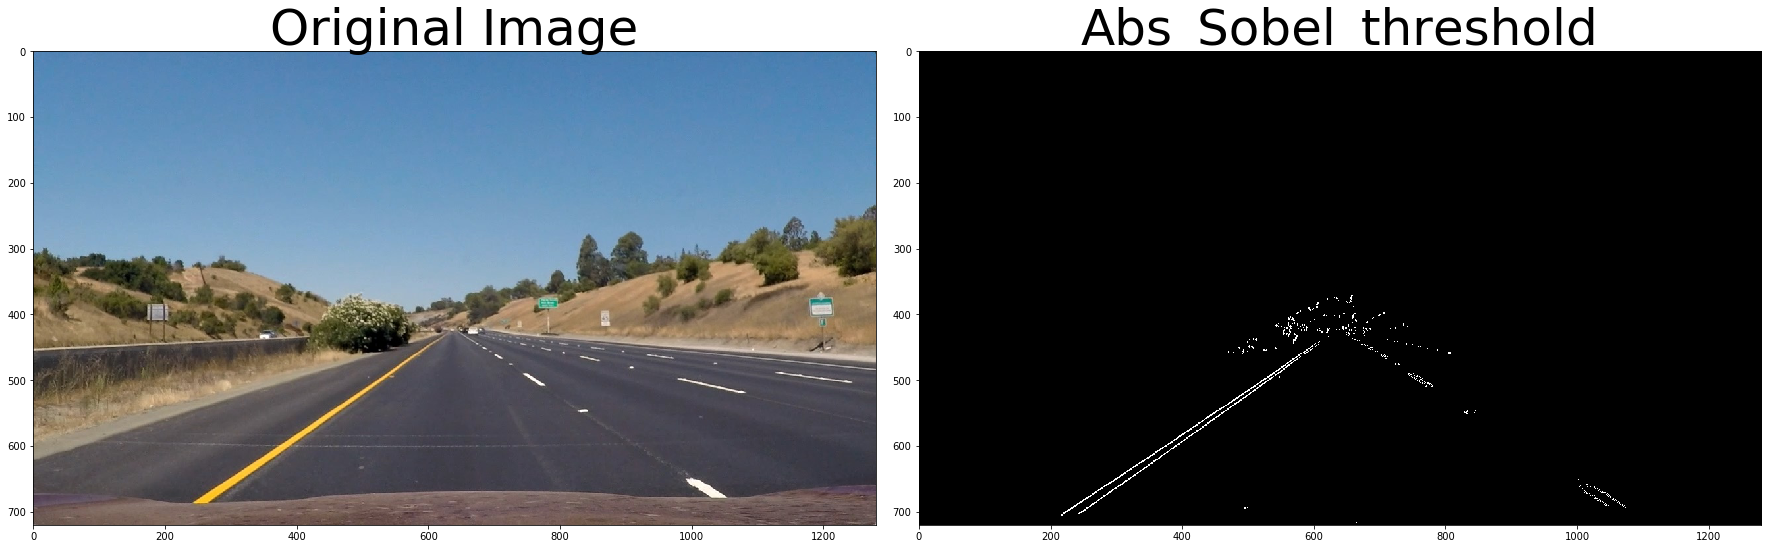

In [10]:
print("Abs_Sobel_threshold")
abs_sob_out=abs_sobel_thresh(undistorted_img,thresh=(50,100))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(abs_sob_out, cmap='gray')
ax2.set_title('Abs_Sobel_threshold', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Magnitude threshold


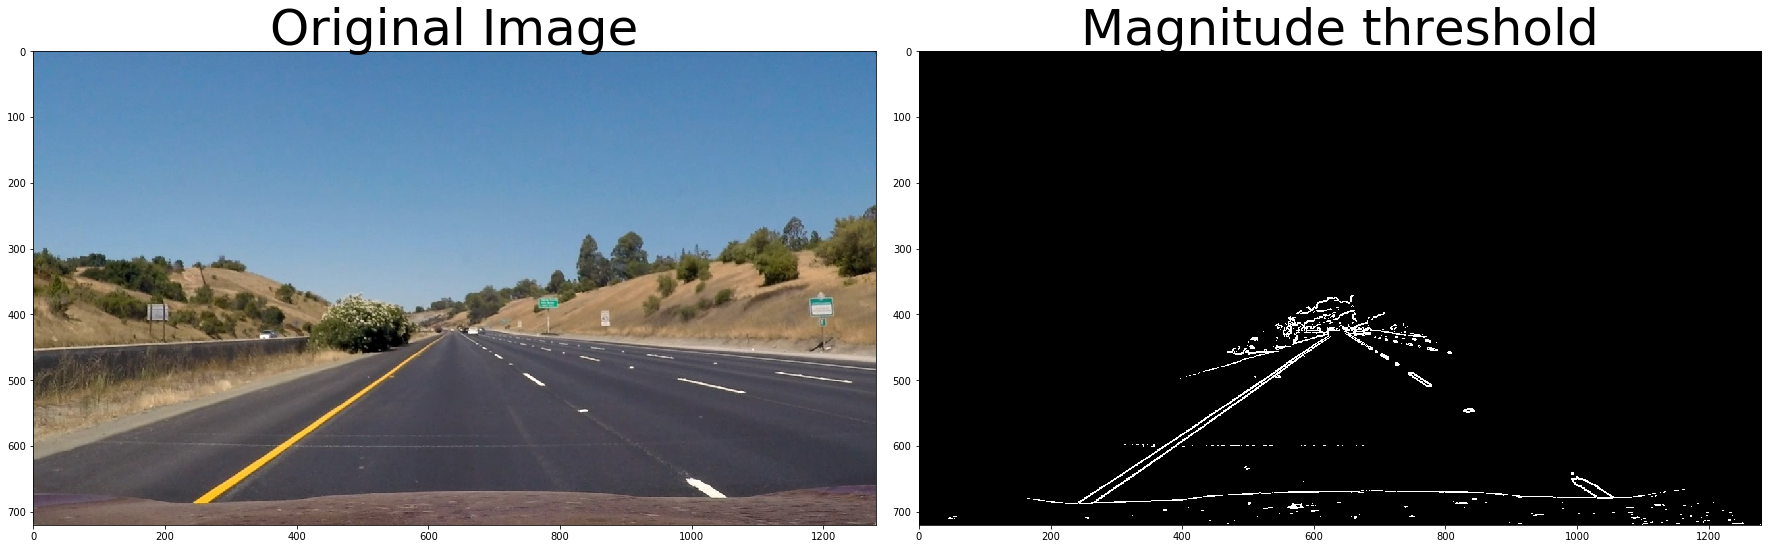

In [11]:
mag_binary_out = mag_thresh(test_img, sobel_kernel=3, mag_thresh=(40, 255))
print('Magnitude threshold')
abs_sob=abs_sobel_thresh(undistorted_img,thresh=(50,100))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary_out, cmap='gray')
ax2.set_title('Magnitude threshold', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Direction threshold value


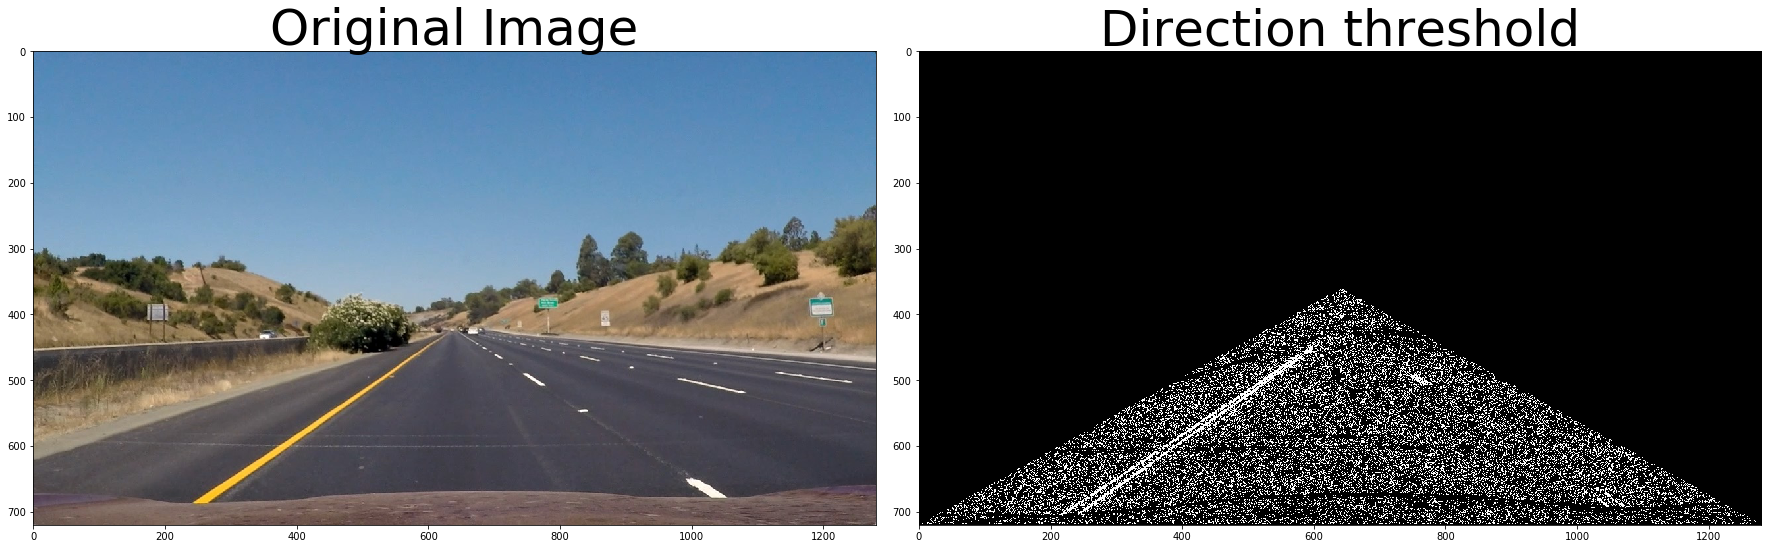

In [12]:
dir_binary_out = dir_threshold(undistorted_img, sobel_kernel=3, thresh=(0.65, 1.05))
print("Direction threshold value")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary_out, cmap='gray')
ax2.set_title('Direction threshold', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

HLS threshold value


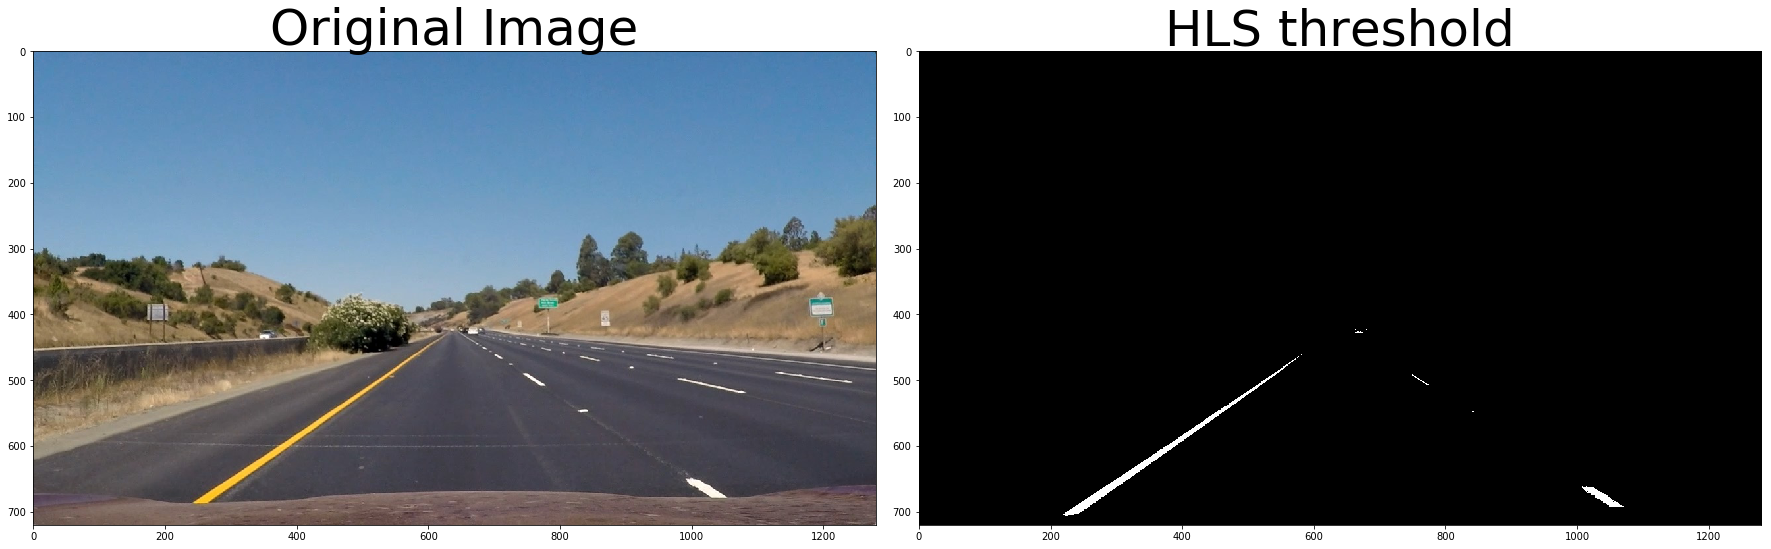

In [13]:
hls_binary_out=hls_image(undistorted_img,thresh=(120,150))
print('HLS threshold value')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary_out, cmap='gray')
ax2.set_title('HLS threshold', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [14]:
#Calculating the overall thresholded value after applying the necessary threshold values
def thresholded(undistorted_img):
    gray=cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2GRAY)
    height,width=gray.shape
    gradx = abs_sobel_thresh(undistorted_img, orient='x', thresh=(50, 100))
    grady = abs_sobel_thresh(undistorted_img, orient='y', thresh=(60, 255))
    mag_binary = mag_thresh(undistorted_img, sobel_kernel=3, mag_thresh=(40, 255))
    dir_binary = dir_threshold(undistorted_img, sobel_kernel=3, thresh=(.65, 1.05))
    hls_binary = hls_image(undistorted_img, thresh=(120, 150))
    #color_binary = color_threshold(undistorted_img)
    combined=np.zeros_like(hls_binary)
    combined[((gradx == 1) |  (hls_binary==1)) ] = 1

    return combined

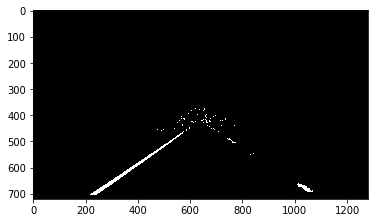

In [15]:
plt.imshow(thresholded(undistorted_img),cmap='gray')

# Caluclating the perspective transform

In [16]:
def unwarp_img(img):
    imsize=(img.shape[1],img.shape[0])
    dimsize=400
    #taking height and width of the mentioned image
    h,w = img.shape[:2]
    # define source and destination points for transform
    src = np.float32([(577,460),(705,460),(260,684),(1050,684)])
    dst = np.float32([(dimsize,0),(w-dimsize,0),(dimsize,h),(w-dimsize,h)])
    h,w = img.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size=(gray.shape[1],gray.shape[0])
    #print(img_size)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, Minv

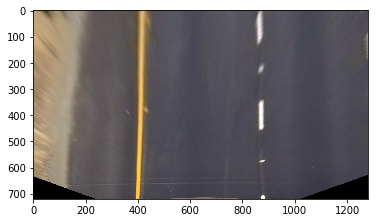

In [17]:
plt.imshow(unwarp_img(undistorted_img)[0])

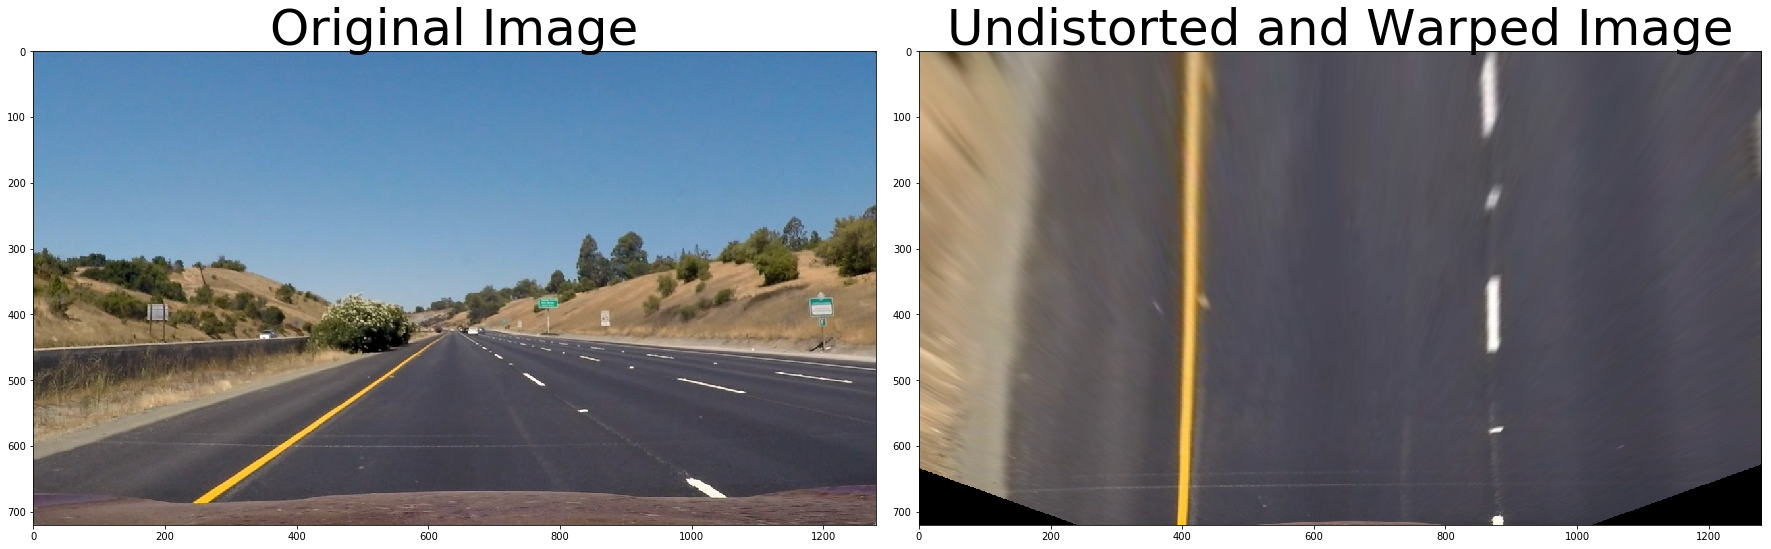

In [18]:
top_down, perspective_M = unwarp_img(undistorted_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [19]:
def pipeline(img):
    undistort_pipe_img=undistort(img)
    thresholded_img=thresholded(undistort_pipe_img)
    top_down, perspective_M = unwarp_img(thresholded_img)
    wraped_top = top_down
    #warpedtop =np.dstack((wraped_top,wraped_top,wraped_top))*255
    return wraped_top

Overall outcome of the pipeline


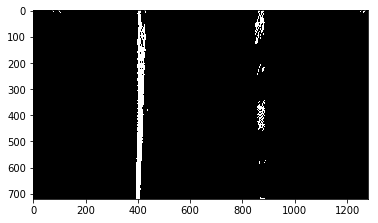

In [24]:
out_image_pipe=pipeline(undistorted_img)
print('Overall outcome of the pipeline')
plt.imshow(out_image_pipe,cmap='gray')

# Displaying the pipeline output all the test images along with the histogram

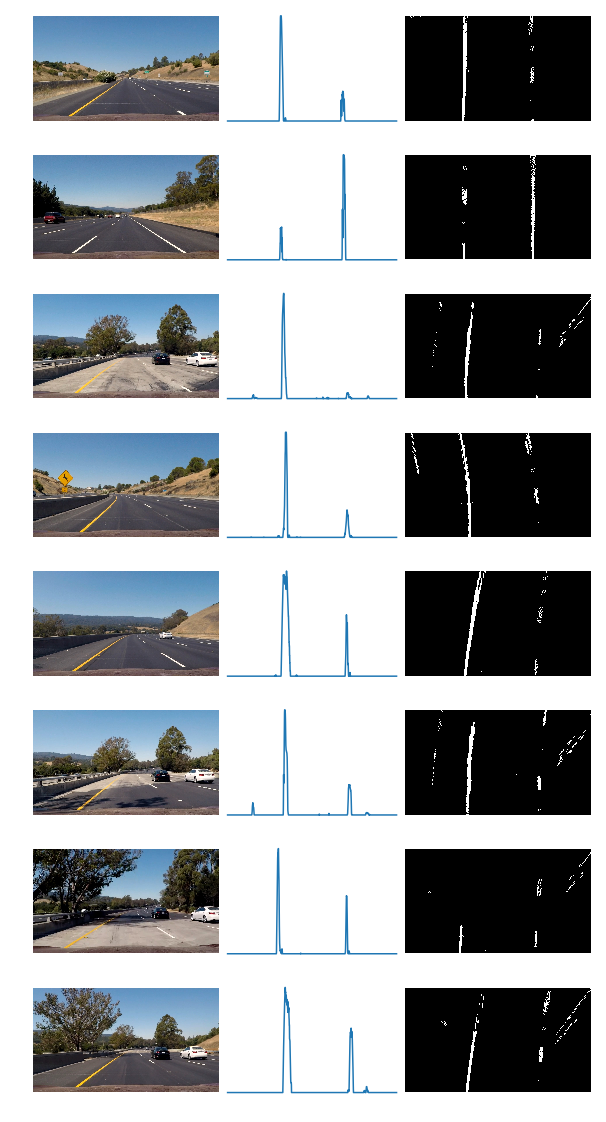

In [26]:
images = glob.glob('./test_images/*.jpg')
# Set up plot
fig, axs = plt.subplots(len(images),3, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()                  
i_val = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin = pipeline(img)
    axs[i_val].imshow(img)
    axs[i_val].axis('off')
    i_val += 1
    histogram = np.sum(img_bin[img_bin.shape[0]//2:,:], axis=0)
    axs[i_val].plot(histogram)
    axs[i_val].axis('off')
    i_val += 1
    axs[i_val].imshow(img_bin, cmap='gray')
    axs[i_val].axis('off')
    i_val += 1


In [30]:
#Clculating the radius of curvature
num_rows = img_bin.shape[0]
def return_radius_of_curvature(x):
    # take meter per pixel in y-dimension
    ym_pix = 30/720 
    # meters per pixel in x-dimension
    xm_pix = 3.7/700 
    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_pix, x*xm_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

# Final Pipeline

In [31]:
def pipeline_new(img):
    img_size=(img.shape[1],img.shape[0])
    img_output = pipeline(img)
    img_bin=img_output
    dimsize=400
    #taking height and width of the mentioned image
    h,w = img.shape[:2]

    #plt.imshow(img_hist)
    histogram = np.sum(img_bin[img_bin.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img_bin, img_bin, img_bin))*255
    
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2) # mid-point of the histogram
    # Finding the peak of the left and right halves of the histogram
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    # Set height of windows
    window_height = np.int(img_bin.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img_bin.shape[0] - (window+1)*window_height
        win_y_high = img_bin.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, img_bin.shape[0]-1, img_bin.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
   
    nonzero = img_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    margin=(right_fitx-left_fitx)/2
    #print(right_fitx,left_fitx,margin)
    #print(margin)
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img_bin, img_bin, img_bin))*255
    
    left_curve_rad = return_radius_of_curvature(left_fitx)
    right_curve_rad = return_radius_of_curvature(right_fitx)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    
    # compute the offset from the center
    lane_center = (right_fitx[num_rows-1] + left_fitx[num_rows-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    
    window_img = np.zeros_like(out_img)

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx,  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    src = np.float32([(577,460),(705,460),(260,684),(1050,684)])
    dst = np.float32([(dimsize,0),(w-dimsize,0),(dimsize,h),(w-dimsize,h)])
    M_inv = cv2.getPerspectiveTransform(dst, src)
    win_img=cv2.warpPerspective(window_img, M_inv, img_size, flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(img, 1, win_img, 0.3, 0)
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result

# Printing the Inverse transform

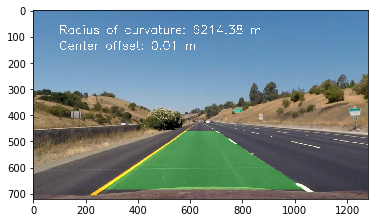

In [32]:
plt.imshow(pipeline_new(undistorted_img))

# Testing the pipeline on another test image

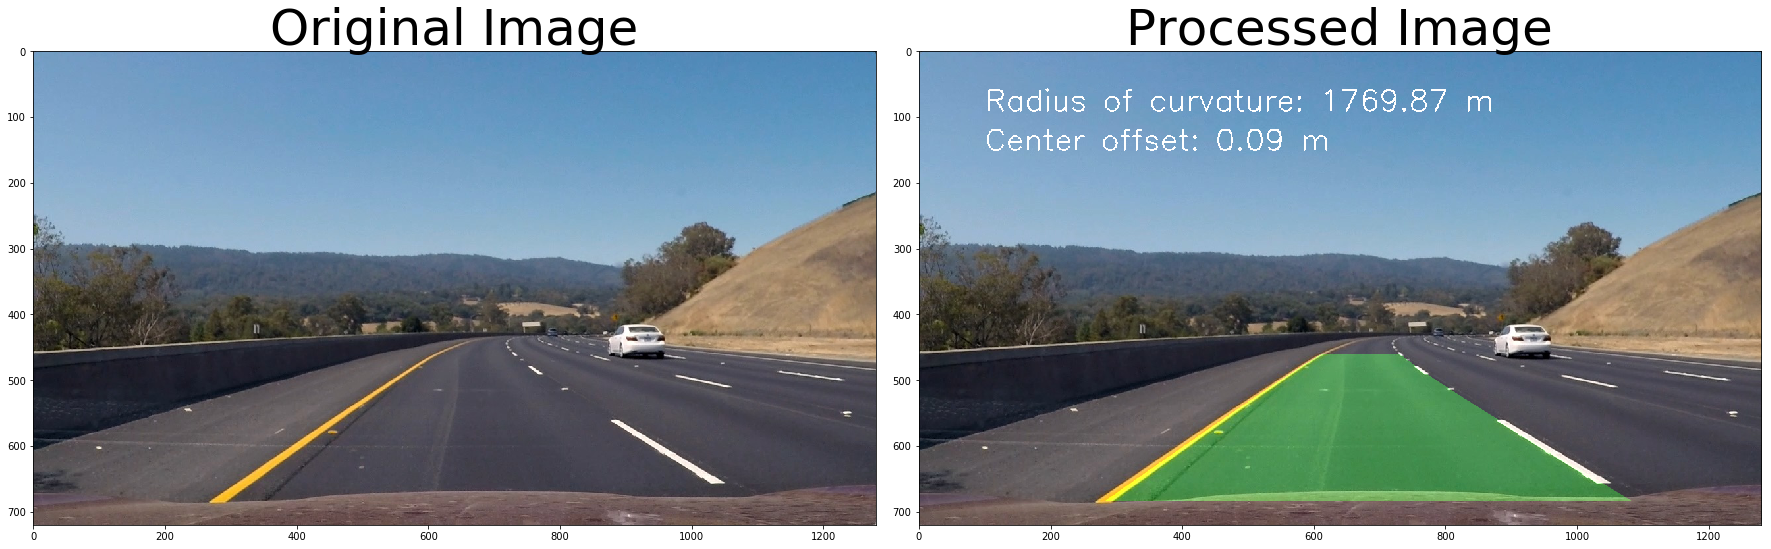

In [34]:
image_to_test = mpimg.imread('./test_images/test3.jpg')
processed = pipeline_new(image_to_test)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_to_test)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Video pipelining

In [37]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
write_output = 'project_video_out_test.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4")
write_clip = clip1.fl_image(pipeline_new)
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video project_video_out_test.mp4
[MoviePy] Writing video project_video_out_test.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:41<00:00,  3.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_test.mp4 

Wall time: 6min 43s
